# Использование моделей АРСС

Один из методов, доступных моделирования и прогнозирования временных рядов, известен как `SARIMAX`, что означает сезонное авторегрессионное интегрированное скользящие средние с экзогенными регрессорами. В частности могут быть такие подвиды модели, как:
* `AR` (AutoRegressive);
* `MA` (Moving Average);
* `SAR` (Seasonal AutoRegressive);
* `SMA` (Seasonal Moving Average);
* `ARMA` (AutoRegressive-Moving Average);
* `ARIMA` (AutoRegressive-Integrated-Moving Average);
* `SARIMA` (Seasonal AutoRegressive-Integrated-Moving Average);
* `SARIMAX` (Seasonal AutoRegressive-Integrated-Moving Average with eXogenous factors).

<!-- В общем случае модель `SARIMAX` имеет и другие частные случаи.  -->
Мы рассмотрим вариант `SARIMA`.

Семейство моделей `SARIMAX` относится к методам параметрической статистики. То есть свойства модели, в том числе, точность ее приближения к данным задаются набором параметров модели. В данном случае параметры называются порядком модели. Могу быть заданы отдельно порядок авторегресионной части модели; порядок скользящего среднего; порядок интегрирования (дифференцирования) и т.д.

Подход  `SARIMAX` был предложен Боксом-Дженкинсом. Методология подхода включает следующие пункты:
* Идентификация модели: используйте графический метод и методы сводной статистики для определения характера тренда и сезонности. А также, чтобы получить представление о порядке производной (d) и порядках авторегрессии p  и q скользящего среднего.
* Оценка модели: оценка коэффициентов регрессионной модели.
* Диагностика модели максимального правдоподобия: используйте графический метод и статистические тесты остаточных ошибок (разности), чтобы определить особенности данных, не охваченной моделью.



Импорт библиотек

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
try:
    import sktime
except:
    !pip install sktime --user
    !pip install pmdarima
    !pip install statsmodels
    !pip install prophet
import sktime

In [9]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

In [10]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)
r2_score = lambda y_pred, y_test: 1-np.sum(np.square(y_pred - y_test))/np.sum(np.square(y_test - np.mean(y_test)))


In [11]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

Импорт данных аналогично предыдущего урока.

Check splitted data size: Train: 144, Test: 117


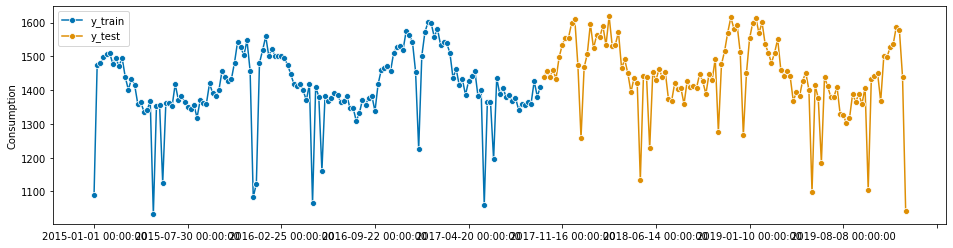

In [12]:
path_ts = 'de_data.csv'

df = pd.read_csv(path_ts, parse_dates=['Date'], index_col="Date")
df=df.fillna(df.mean())

y = df.Consumption.asfreq('7d')

TEST_SIZE = int(0.45*y.size)

y_train, y_test = temporal_train_test_split(y, test_size=TEST_SIZE)

print(f'Check splitted data size: Train: {y_train.shape[0]}, Test: {y_test.shape[0]}')

sktime.utils.plotting.plot_series(y_train, y_test, labels=["y_train", "y_test"]);


## SARIMA Forecasting

Для модели `AutoregRessive Integrated Moving Average` (`ARIMA`) существует три  параметра (порядка) (`p, d, q`):
* `p` - **авторегрессивная часть модели**. Этот параметр позволяет учесть влияние прошлых значений на текущее для модели. Прошлые значения здесь называются запаздывающими наблюдениями (также известными как «запаздывание» или «лаг»). Интуитивно это похоже на утверждение, что завтра, вероятно, будет тепло, если в последние 3 дня было тепло. Другими словами, здесь мы можем сказать, что текущее значение температуры зависит от последних трех значений.

* `d` – **интегрирование модели**. Этот параметр включает в себя степень различия лагов (то есть количество прошлых временных точек, которые нужно вычесть из текущего значения), чтобы сделать временной ряд стационарным (чтобы исключить часть тренда). Интуитивно это было бы похоже на утверждение о том, что, вероятно, будет одно и то же повышение температуры каждый день (или одно и то же ускорение для второй производной и т.д.).

* `q` - **скользящая средняя часть модели**. Этот параметр позволяет представить остаточную часть (шум, ошибку) модели как линейную комбинацию остаточных значений, наблюдаемых в предыдущие моменты времени.

Если в модели видно достаточно сильное влияние сезонной составляющей, то следует перейти к модели `ARIMA` с сезонными эффектами (`Seasonal ARIMA - SARIMA`).  Как правило такая модель обозначается как 
$$SARIMA (p, d, q) (P, D, Q) s.$$ 
Где
* (`p, d, q`) -  несезонные параметрами, описанными выше; 
* (`P, D, Q`) - сезонные порядки, которые следуют тому же порядку определений как и описанные выше, но применяются к сезонной составляющей временного ряда;
* `s` - это периодичность временного ряда (например, 4 для квартальных периодов, 12 для годовых периодов и т.д.).

Рассмотрим процедуру ручного выбора порядков модели. Как правило, начинать следует с дифференцирования для достижения стационарности. Как правило, это `1-3` порядок, реже - больше.

Правильный порядок дифференцирования (`d, D`) это порядок разности, который делает временной ряд шумоподобным
т.е. значения колеблется около четко определенного среднего и имеют почти постоянный разброс значений. При этом рекомендуется использовать сезонную производную только в случае сильного сезонного влияния.


Для проверки стационарности после дифференцирования можно использовать несколько методов, в том числе:
* **Скользящая статистика**: построение скользящего среднего и скользящего стандартного отклонения. Идея этого метода в том, что временные ряды являются стационарными, если они остаются неизменными во времени. Скользящая статистика визуально показывает стационарность среднего значения.
* **Статистические тесты, в т.ч. Расширенный тест Дики-Фуллера**: временной ряд считается стационарным, если
значение `p-value` низкое (в соответствии с нулевой гипотезой), а критические значения с доверительными интервалами `1%, 5%, 10%` максимально близки к табличному значению параметра `ADF` (такой параметр принято называть `статистика ADF`). Если тест `ADF` показывает, что статистика `ADF` далека от критических значений, а значение `p-value` превышает пороговое значение (например (0,05), то ряд  является нестационарным. В обратном случае ряд следует признать стационарным.
 
Проверим стационарность для нашего ряда. 

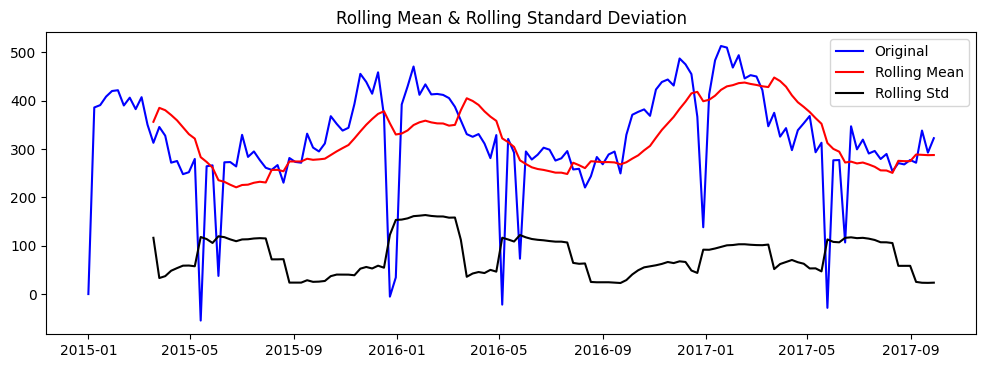

In [13]:
rolling_mean = y_train.rolling(window = 12).mean()
rolling_std  = y_train.rolling(window = 12).std()

plt.figure(figsize=(12,4), dpi=100)

plt.plot(y_train-y_train[0],      color = 'blue',  label = 'Original')
plt.plot(rolling_mean-y_train[0], color = 'red',   label = 'Rolling Mean')
plt.plot(rolling_std,             color = 'black', label = 'Rolling Std')

plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [14]:
P_THRESHOLD = 0.05
def check_ADF(y, p_threshold = P_THRESHOLD):
    result = adfuller(y)
    adf_value = result[0]
    p_value   = result[1]
    print('ADF Statistic: {:.4f}'.format(adf_value))
    print('p-value: {:.4f}'.format(p_value))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.4f}, {}'.format(key, value, 'outperformed' if adf_value>value else ""))    
    print(f'Result: The series is {"not " if p_value < p_threshold else ""}stationary')
    return result

check_ADF(y_train, p_threshold = P_THRESHOLD);

ADF Statistic: -3.3857
p-value: 0.0115
Critical Values:
	1%: -3.4783, outperformed
	5%: -2.8826, 
	10%: -2.5780, 
Result: The series is not stationary


В данной ситуации оказалось так, что ряд не стационарен. В этом случае стационарности можно добиться дифференцированием. Рассмотрим классической дифференцирование.  

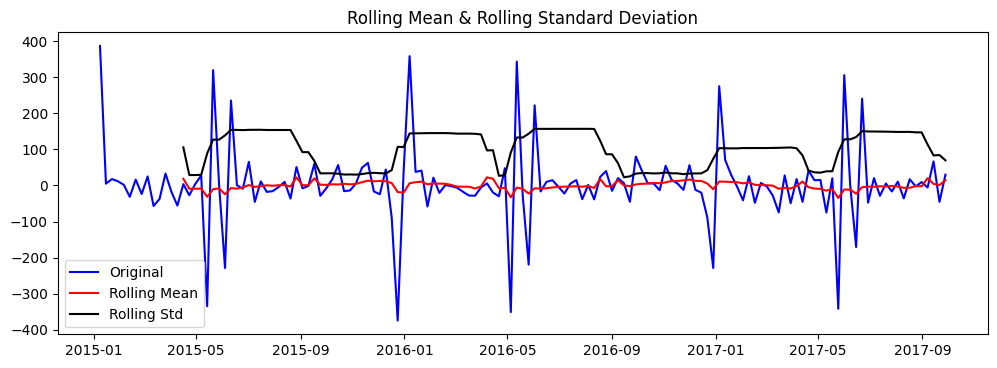

ADF Statistic: -8.5914
p-value: 0.0000
Critical Values:
	1%: -3.4783, 
	5%: -2.8826, 
	10%: -2.5780, 
Result: The series is not stationary


In [15]:
y_diff = y_train[:].diff(1).dropna()

rolling_mean = y_diff.rolling(window = 15).mean()
rolling_std  = y_diff.rolling(window = 15).std()

plt.figure(figsize=(12,4), dpi=100)

plt.plot(y_diff,       color = 'blue',  label = 'Original')
plt.plot(rolling_mean, color = 'red',   label = 'Rolling Mean')
plt.plot(rolling_std,  color = 'black', label = 'Rolling Std')

plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

result = check_ADF(y_diff)

Как и следовало ожидать (в ряду преобладает сезонная составляющая) ряд по прежнему не стационарен. 

<!-- 
Попробуем несколько вариантов с использованием сезонного дифференцирования. Отметим, что мы подобрали оптимальный период дифференцирования, который соответствует 3 месяцам  (13 недель). В общем случае следует начинать с наиболее очевидного значения периода (например 1 год = 52 недели), но всегда можно попробовать несколько вариантов. Если выбран  Для выбора периода можно использовать, например, следующий код.
 ```python 
for s in range(1,52): #month, 3 month, quarter, half-year, year  
    p_value = adfuller(y_train[:].diff(s).dropna())[1]
    if  p_value> P_THRESHOLD: print(f'season {s}, p-value {p_value:.4f}')
```
В результатах выше 11 лаг максимален, однако предположительно интерпретировать мы можем лишь 13 лаг (3 месяца). Посмотрим, как выглядят графики для этого лага
-->

Попробуем теперь модель с сезонным дифференцированием.

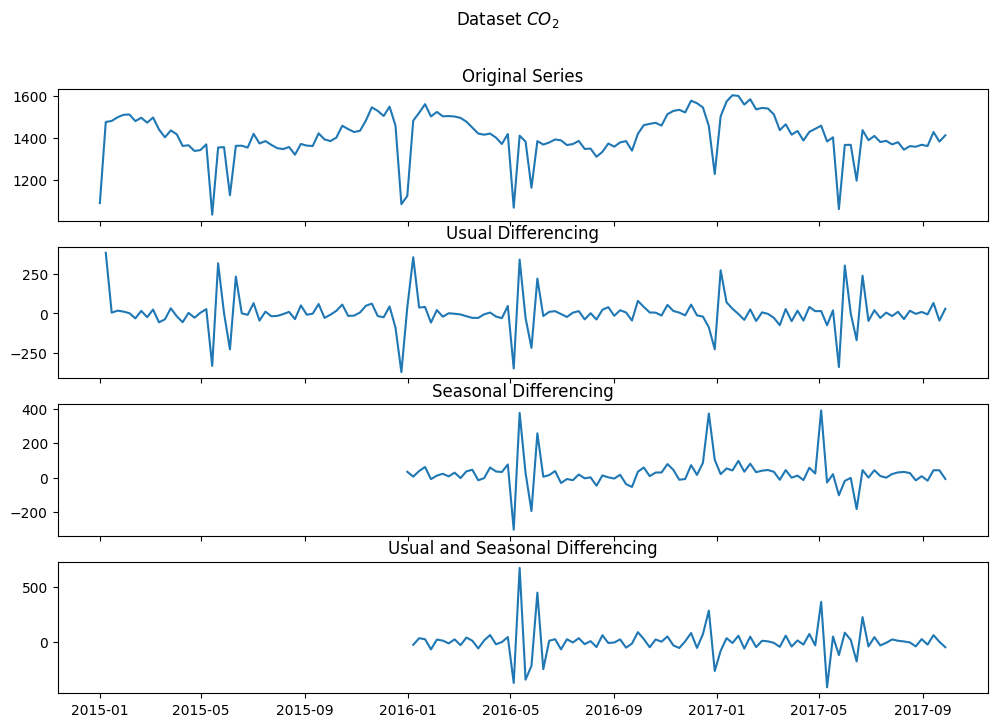

In [16]:
SEASON = 52

# Plot
fig, axes = plt.subplots(4, 1, figsize=(12,8), dpi=100, sharex=True)

# Original Series
axes[0].plot(y_train[:])
axes[0].set_title('Original Series')

# Usual Differencing
axes[1].plot(y_train[:].diff(1))
axes[1].set_title('Usual Differencing')

# Seasinal Differencing
axes[2].plot(y_train[:].diff(SEASON))
axes[2].set_title('Seasonal Differencing')

# Seasinal and Usual Differencing
axes[3].plot(y_train[:].diff(1).diff(SEASON))
axes[3].set_title('Usual and Seasonal Differencing')

plt.suptitle('Dataset $CO_2$', fontsize=12)
plt.show()

В последнем случае мы имеем более не менее стационарный случай. Проверим это при помощи теста.

In [17]:
y_sdif = y_train[:].diff(1).diff(SEASON).dropna()
results = check_ADF(y_sdif);

ADF Statistic: -8.0074
p-value: 0.0000
Critical Values:
	1%: -3.5079, 
	5%: -2.8954, 
	10%: -2.5848, 
Result: The series is not stationary


Хотя тест дал не лучшие результаты, мы можем заключить что предварительной оценкой порядков дифференцирования (интегрирования) являются: $d=1; D=1; s=52$. 

После выбора порядков дифференцирования следует перейти к оценке порядков авторегрессии и скользящего среднего. Как правило, в ручную, эти параметры выбираются при помощи автокорреляционной и частичной автокорреляционной функций (`ACF` и `PACF` соответственно).

Как правило, графики `ACF` и `PACF` состоят из точек, соответствующих значениям этих функций для т.н. "лагов" - то есть значений вычисленных для т.н. "запаздывания" одной из копий функции относительно другой (см. определение `ACF` и `PACF`). Также на графиках обычно отображают доверительные интервалы, которые имеют вид конуса в районе нуля. Эти интервалы показывают порог проверки гипотезы о белом шуме. Другими словами все значение ниже уровень доверительного интервала скорее всего не имеют статистической значимости.  По умолчанию  установлен доверительный интервал 95%, что предполагает, что значения корреляции за пределами этого интервала, скорее всего, являются корреляцией, а не статистической случайностью.

При  ручном выборе порядков модели рекомендуются следующие правила:
* **Количество слагаемых `AR` (AR порядок)** определяется как последнее значение лага `PACF` перед быстрым уменьшением от положительных значений до нуля.
* **Количество слагаемых скользящего среднего (`MA`)** определяется как последнее значение лага `ACF` перед быстрым увеличением от отрицательных значений до нуля.
* **Добавьте слагаемое `SAR`**, если значения `PACF` периодически положительны. 
* **Порядок `SAR`** может быть оценен из `PACF`. Посмотрите на количество значений лагов выше уровня шума, которые кратны периоду сезона. Например, если период равен `24`, и мы видим, что `24-е` и `48-е` запаздывания значительны в `PACF`, это означает, что начальное `P` должно быть `2`.
* **Добавьте член `SMA`**, если значения `ACF` периодически отрицательный.
* **Порядок `SMA`** может быть оценен из `ACF`. Посмотрите на количество отрицательных значений лагов выходящих за уровень шума, которые кратны периоду сезона. 
* Если временной ряд немного недодифференцирован, добавьте дополнительное слагаемое в `AR`.
* Если ваши ряды немного передифференцирован, добавьте дополнительные слагаемое в `MA`.
* Старайтесь избегать использования более одного или двух сезонных порядков (`SAR + SMA`) в одной модели, так как это может привести к переобучению данных и/или проблемам в точности оценок.
* Если все значения `ACF` и `PACF` кроме `0` не выходят за доверительный интервал следует считать модель белым шумом.

Рассмотрим графики `ACF` и `PACF`.

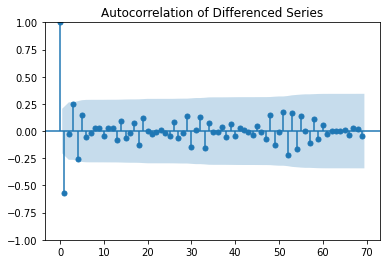

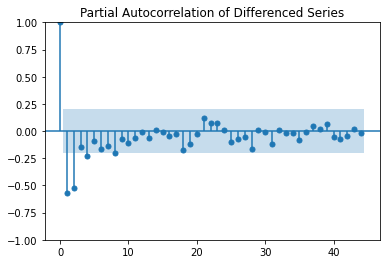

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Usual Differencing
plot_acf(y_sdif, title='Autocorrelation of Differenced Series', lags=np.arange(70) );plt.show()
# Usual Differencing
plot_pacf(y_sdif, title='Partial Autocorrelation of Differenced Series', method='ywm', lags=np.arange(45));plt.show()
plt.show();

Из графиков выше следует следующий выбор параметров.
* $2$ порядка `AR`  (1 и 2 лаги `PACF` ниже нуля); 
* $0$ порядок `MA`  (на `ACF` видна некоторая нестационарность, но 1 и 2 лаги не превысили доверительный интервал);
* $0$ порядок `SAR` (на `PACF` нет значимых лагов выше нуля);
* $0$ порядок `SMA` (на `ACF` нет значимых лагов ниже нуля);
* Ряд немного недодифференцирован, поэтому установим $3$ порядок `AR`; 

Теперь давайте проверим модель $SARIMA (3,1,0)(0,1,0)52.$ Напомним, что после оценки предварительных параметров модели, чаще всего, необходимо провести  некоторую до настройку (подбор) значений параметров. Это делается по нескольким критериям, в том числе особым критериям выбора порядка ARMA моделей, например `BIC, AIC` и т.д.     
Отметим, что в данном случае мы будем рассматривать класс `SARIMAX` из пакета `SKTime`. Данный пакет основан на функциях из библиотеки [`statsmodels`](https://www.statsmodels.org/stable/index.html).

In [19]:
forecaster = SARIMAX(order=(3, 1, 0), seasonal_order=(0, 1, 0, 52))
forecaster.fit(y_train)
print(forecaster.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        Consumption   No. Observations:                  144
Model:             SARIMAX(3, 1, 0)x(0, 1, 0, 52)   Log Likelihood                -544.223
Date:                            Tue, 26 Jul 2022   AIC                           1098.445
Time:                                    16:39:06   BIC                           1110.999
Sample:                                01-01-2015   HQIC                          1103.510
                                     - 09-28-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.3869     11.340     -0.034      0.973     -22.612      21.839
ar.L1         -0.9386      0.072   

Выведенные результаты аппроксимации модели раскрывает достаточно много информации. В первой таблице представлена общая информация, включая критерии качества (`AIC, BIC` и `HQIC`). Таблица
посередине - это таблица коэффициентов, где значения столбца `coef` - это веса
соответствующих слагаемых. Значение `sigma2` – это `RSS` (средне квадратическая) ошибка модели. В последней
таблице представлены результаты различных статистических тестов для полученных остатков.

Помимо табличного представления, мы можем проводить диагностику остатков графическим способом. Напомним, что остатки в данном контексте означают разность модели, аппроксимированной при помощи `SARIMA` и тренировочных данных.
Отметим, что данный способ не является стандартным методом класса `SARIMAX`, однако присутствует в нем.

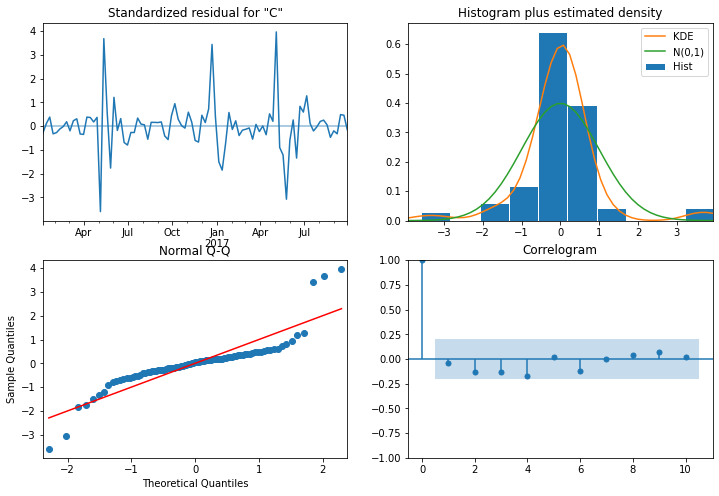

In [20]:
forecaster._fitted_forecaster.plot_diagnostics(figsize=(12,8));

На графиках выше мы видим:
* *верхний левый  график*: остаточные ошибки колеблются около нулевого среднего, однако имеют несколько не равномерную дисперсию, возможно модель недодифференцирована.
* *верхний правый график*: остаток имеет распределение, похожее на нормальное распределение, но с большими "хвостами". 
* *нижний правый график*: график `Q-Q` показывает отклонения от нормального распределения. 
* *нижний левый график*: автокорреляционная функция не показывает значительных (статистически значимых) отличий от нормального распределения. 

Проведенный анализ показывает, что мы можем улучшить нашу модель. При ручном поборе порядка модели следует отдавать предпочтения моделям с наименьшим значением критериев качества и с наименьшей ошибкой `RSS`.

В качестве первого предположения мы можем попытаться увеличить порядок дифференцирования модели.  После можно попробовать несколько значений разных порядков.

c:\users\ronkin\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


                                     SARIMAX Results                                      
Dep. Variable:                        Consumption   No. Observations:                  144
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 52)   Log Likelihood                -539.528
Date:                            Tue, 26 Jul 2022   AIC                           1091.057
Time:                                    16:39:44   BIC                           1106.122
Sample:                                01-01-2015   HQIC                          1097.135
                                     - 09-28-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -3.5024     32.034     -0.109      0.913     -66.288      59.284
ar.L1         -0.8226      0.071   

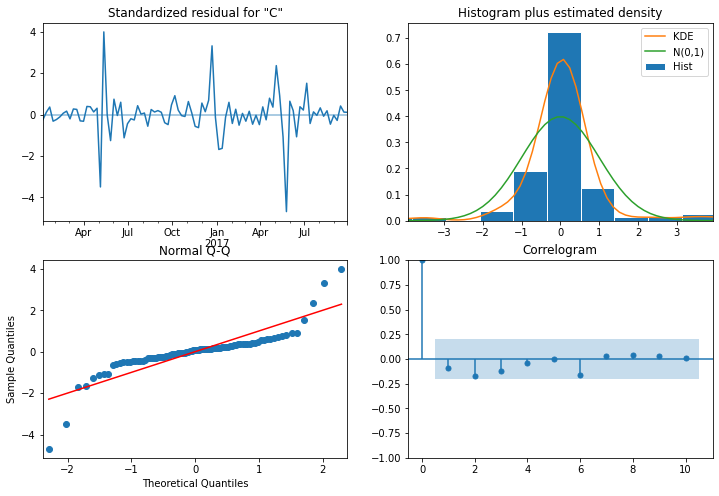

In [21]:
forecaster = SARIMAX(order=(2, 1, 0), seasonal_order=(2, 1, 0, 52))
forecaster.fit(y_train)
print(forecaster.summary())
forecaster._fitted_forecaster.plot_diagnostics(figsize=(12,8));

Теперь давайте попробуем визуализировать предсказания нашей модели.

sMAPE = 0.049


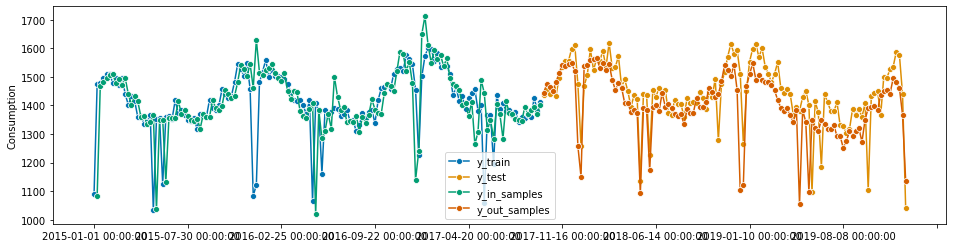

In [22]:
# forecaster = SARIMAX(order=(2, 1, 0), seasonal_order=(2, 1, 0, 52))
# forecaster.fit(y_train)

fhin = ForecastingHorizon(y_train.index[1:], is_relative=False)
y_in_samples = forecaster.predict(fhin)

fhout = ForecastingHorizon(y_test.index, is_relative=False)
y_out = forecaster.predict(fhout)

plot_series(y_train, y_test, y_in_samples, y_out, labels=["y_train", "y_test", "y_in_samples", "y_out_samples"])

print(f'sMAPE = {smape(y_out.values, y_test.values):.3f}')

 Полученный результаты достаточно хорошо описывают модель, однако, рискнем предположить, что можно достичь и лучшей аппроксимации. Однако, также отметим что помимо полученных значений предсказаний важно и предсказание их дисперсии. Давайте попробуем построить такие интервалы.

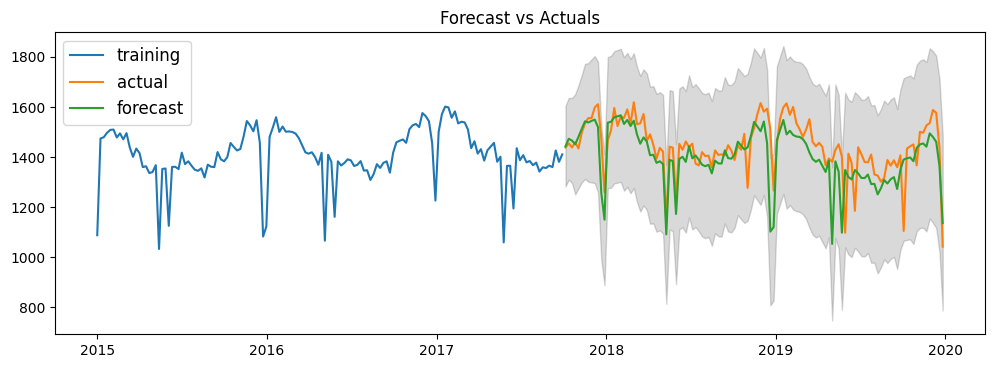

In [23]:
# Forecast
forecast_res = forecaster._fitted_forecaster.get_forecast(y_test.size, alpha=0.01, dynamic=False)  # 95% conf

forecast = forecast_res.predicted_mean

# Make as pandas series
fc_series = pd.Series(forecast.values, index=y_test.index)

lower_series = pd.Series(forecast_res.conf_int()['lower Consumption'], index=y_test.index)
upper_series = pd.Series(forecast_res.conf_int()['upper Consumption'], index=y_test.index)

# Plot
plt.figure(figsize=(12,4), dpi=100)

plt.plot(y_train, label='training')
plt.plot(y_test,  label='actual')
plt.plot(fc_series, label='forecast')

plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', 
                 alpha=0.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.show()


Во многих случаях, помимо ручного поиска параметров `ARMA` могут быть использованы инструменты автопоиска. Мы рассмотрим один из таких инструментов в рамках пакета `SKTime` это `AutoARIMA`. Данный класс основан функциях из библиотеки [`pmdarima`](http://alkaline-ml.com/pmdarima/).

Объект класса `AutoARIMA` позволяет задать границы поиска параметров моделей, а также метод тестирования и ряд других параметров. В качестве примера давайте попробуем найти автоматическое предложение параметров.

In [24]:
model = AutoARIMA(start_p=1,  # начальный порядок AR
                  d=1,        # Порядок производной
                  start_q=0,  # начальный порядок MA
                  max_p=5,    # конечный порядок AR
                  max_q=5,    # конечный порядок MA                 
                  seasonal=True,  # Использовать SARIMA  
                  start_P=0,  # начальный порядок SAR
                  start_Q=0,  # начальный порядок SMA                 
                  D=1,        # Порядок сезонной производной
                  sp=52,      # Период сезонности
                  max_order = 7, # Максимальный порядок p+q+P+Q 
                  trace  = True,   # отчет он-лайн
                  stepwise = True, # метод ускоренного выбора параметров.
                  n_jobs = 1,      # для stepwise парралелизм не доступен.
                  error_action='ignore',  
                  suppress_warnings=True)

model.fit(y_train)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,1,0)[52] intercept   : AIC=1125.065, Time=0.44 sec
 ARIMA(0,1,0)(0,1,0)[52] intercept   : AIC=1158.761, Time=0.33 sec
 ARIMA(1,1,0)(1,1,0)[52] intercept   : AIC=1121.163, Time=5.92 sec
 ARIMA(0,1,1)(0,1,1)[52] intercept   : AIC=inf, Time=5.78 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1156.762, Time=0.43 sec
 ARIMA(1,1,0)(2,1,0)[52] intercept   : AIC=inf, Time=30.73 sec
 ARIMA(1,1,0)(1,1,1)[52] intercept   : AIC=inf, Time=16.04 sec
 ARIMA(1,1,0)(0,1,1)[52] intercept   : AIC=1121.129, Time=5.61 sec
 ARIMA(1,1,0)(0,1,2)[52] intercept   : AIC=inf, Time=26.87 sec
 ARIMA(1,1,0)(1,1,2)[52] intercept   : AIC=inf, Time=29.83 sec
 ARIMA(0,1,0)(0,1,1)[52] intercept   : AIC=inf, Time=7.44 sec
 ARIMA(2,1,0)(0,1,1)[52] intercept   : AIC=inf, Time=13.07 sec
 ARIMA(1,1,1)(0,1,1)[52] intercept   : AIC=inf, Time=6.32 sec
 ARIMA(2,1,1)(0,1,1)[52] intercept   : AIC=inf, Time=23.75 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=1119.137, Time=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 52)   Log Likelihood                -556.568
Date:                              Tue, 26 Jul 2022   AIC                           1119.137
Time:                                      16:44:51   BIC                           1126.669
Sample:                                           0   HQIC                          1122.175
                                              - 144                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5346      0.051    -10.555      0.000      -0.634      -0.435
ma.S.L52      -0.4727      0.133     -3.541      0.000      -0.734      -0.211
sigma2      1.054e+04   1221.051      8.628      0.000    8142.195    1.29e+04
===================================================================================
Ljung-Box (L1) (Q):                   8.38   Jarque-Bera (JB):               133.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                             0.23
Prob(H) (two-sided):                  0.02   Kurtosis:                         8.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

И так протестируем модель, выбранную автоматически.

c:\users\ronkin\appdata\local\programs\python\python37\lib\site-packages\pmdarima\arima\arima.py:692: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


sMAPE = 0.042


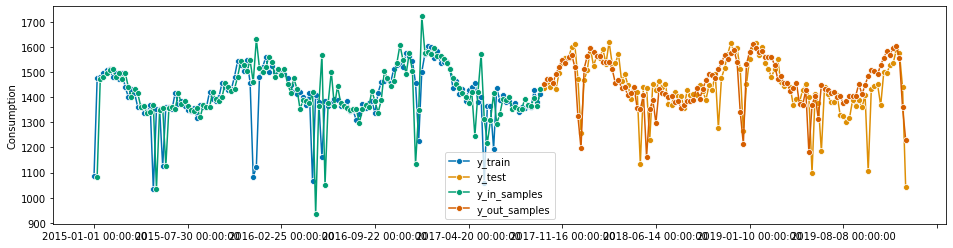

In [25]:
fhin = ForecastingHorizon(y_train.index[1:], is_relative=False)
y_in_samples = model.predict(fhin)

fhout = ForecastingHorizon(y_test.index, is_relative=False)
y_out = model.predict(fhout)

plot_series(y_train, y_test, y_in_samples, y_out, labels=["y_train", "y_test", "y_in_samples", "y_out_samples"])

print(f'sMAPE = {smape(y_out.values, y_test.values):.3f}')

Полученная модель оказалась лучше найденной вручную. Однако, подчеркнем, что на практике такое не всегда бывает. В частности, можно заметить, что критерий AIC для модели, подобранной вручную был несколько ниже, чем для проверенных автоматически. Часто, авто поиск модели можно использовать лишь как некоторое очень хорошее начальной предположение.

Также отметим, что в рамках пакета `SKTime` доступны и другие методы работы с `ARMA` моделями. Например, вместо поиска производных можно провести предварительное удаление сезонности данных. 


sMAPE = 0.047


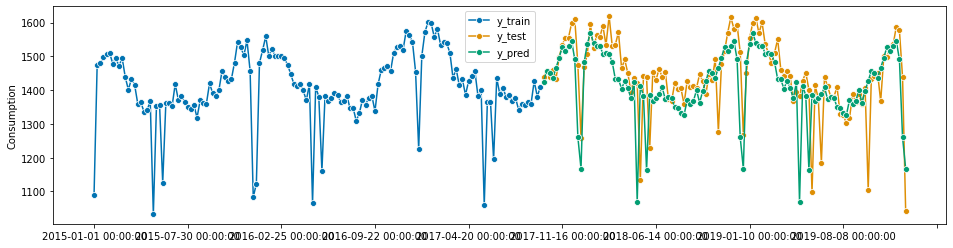

In [26]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer

forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=52)),
        ("forecast", ARIMA( order=(2, 0, 0), seasonal_order=(0, 0, 0, 0),  )),
    ]
)

forecaster.fit(y_train)

fh = ForecastingHorizon(y_test.index, is_relative=False)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Точность такого результата оказывается несколько ниже, однако, скорость обучения модели значительно увеличивается. В дополнение к этому такой подход позволяет проводить раздельно учитывать несколько сезонных составляющих в данных.


На сегодняшний день семейство моделей `ARIMA` является одним из основных методов предсказания временных рядов. Метод отлично подходит для однопеменных временных рядов. Метод хорошо работает как для рядов небольшой длительности, так и для достаточно длинных рядов. При этом метод подходит как для детерминированных, так и для случайных типа тренд. А также, само по себе описание ряда при помощи коэффициентов может быть важным признаком в ряде методов машинного обучения. 

Также отметим, что часто метод `ARIMA` сравнивается c алгоритмом `Prophet`, который в свою очередь представляет собой некоторую адоптацию обобщенной регрессии к бизнесс процессом. Алгоритм `Prophet` в некоторых случаях может давать более точные предсказания, но не всегда. Давайте сравним результаты, полученные методами `ARIMA` и `Prophet` для нашего примера.

16:44:57 - cmdstanpy - INFO - Chain [1] start processing
16:45:00 - cmdstanpy - INFO - Chain [1] done processing


sMAPE = 0.033


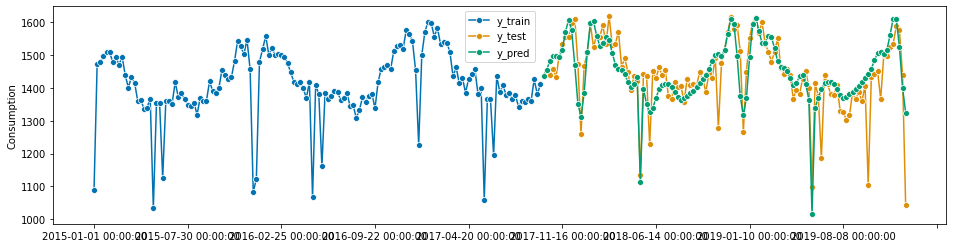

In [27]:
from sktime.forecasting.fbprophet import Prophet

forecaster = Prophet(freq='1w',
                    seasonality_mode='additive',
                    add_country_holidays={'country_name': 'Germany'},
                    yearly_seasonality=True)

forecaster.fit(y_train)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

После правильной настройки метод алгоритм `Prophet` оказался лучше. Еще раз отметим, что в каждом случае следует выбирать свой вариант предсказателя.